In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pickle

# Load the dataset
data = pd.read_csv('../data/driving_data.csv')

# Display the first few rows of the dataframe
print(data.head())

# Handling missing values
data.dropna(inplace=True)

# Feature engineering: Create additional features if needed
data['Speed_Change'] = data['Speed(km/h)'].diff().fillna(0)
data['Acceleration_Change'] = data['Acceleration(m/s^2)'].diff().fillna(0)

# Label encoding (example: creating a simple category based on speed)
def categorize_driving(row):
    if row['Speed(km/h)'] > 70:
        return 'Fast'
    elif row['Speed(km/h)'] > 50:
        return 'Moderate'
    else:
        return 'Slow'

data['Driving_Category'] = data.apply(categorize_driving, axis=1)

# Convert categorical columns to numerical values if necessary
data['Driving_Category'] = data['Driving_Category'].map({'Slow': 0, 'Moderate': 1, 'Fast': 2})

# Splitting data into features and target variable
X = data[['Speed(km/h)', 'Acceleration(m/s^2)', 'Heading_Change(degrees)', 'Speed_Change', 'Acceleration_Change']]
y = data['Driving_Category']

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model performance
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save the trained model to a file
with open('../models/driving_behavior_model.pkl', 'wb') as f:
    pickle.dump(model, f)


  TripId  Time_Step  Speed(km/h)  Acceleration(m/s^2)  \
0    T-1          1           65                -0.28   
1    T-1          2           64                -0.28   
2    T-1          3           64                 0.00   
3    T-1          4           65                 0.28   
4    T-1          5           66                 0.28   

   Heading_Change(degrees)   Latitude  Longitude  
0                        0  39.981798 -83.033740  
1                        6  39.981688 -83.033573  
2                        0  39.981581 -83.033420  
3                        6  39.981470 -83.033276  
4                        0  39.981345 -83.033133  
Confusion Matrix:
[[3802    0    0]
 [   0 1616    0]
 [   0    0 2476]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3802
           1       1.00      1.00      1.00      1616
           2       1.00      1.00      1.00      2476

    accuracy                        

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve


In [10]:
# Obtain learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    model, X_scaled, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)


In [11]:
# Calculate the mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)


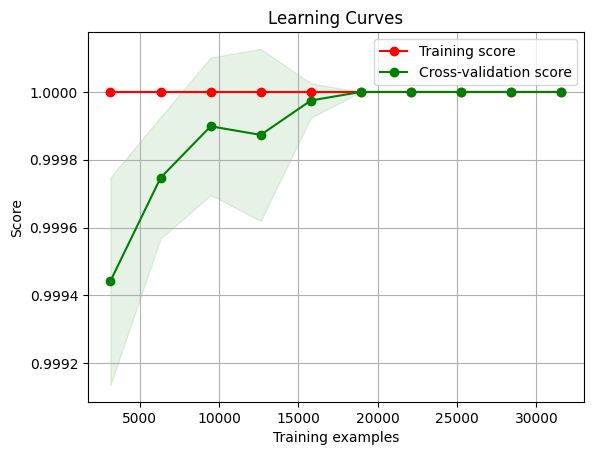

In [12]:
# Plot learning curves
plt.figure()
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_mean, 'o-', color="g", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="g")

plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()
